In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import os
from sklearn.metrics import roc_auc_score

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8') # pretty matplotlib plots


## Load Data

In [3]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))
x_train_df

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)


,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...
...,...,...
2395,yelp,The sweet potato fries were very good and seas...
2396,yelp,I could eat their bruschetta all day it is dev...
2397,yelp,Ambience is perfect.
2398,yelp,We ordered the duck rare and it was pink and t...


In [4]:
# df to list
tr_text_list = x_train_df['text'].values.tolist()

In [5]:
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()
len(y_train_list)

2400

In [6]:
len(y_train_list)

2400

## Partition sentences into words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
vectorizer = CountVectorizer( max_df= 0.5, min_df=10)

### How big is my vocabulary?

In [9]:
x = vectorizer.fit_transform(tr_text_list)
vocab = vectorizer.get_feature_names_out()
vocab.shape[0]

383

In [10]:
x_train_NV = x.toarray()
x_train_NV.shape # N is the number of sentences, and V is the number of vocabulary

(2400, 383)

In [11]:
N = x_train_NV.shape[0]
V = x_train_NV.shape[1]
N,V

(2400, 383)

### Get Normal

In [12]:
x_normal = x_train_NV

In [13]:
y_train_list = np.array(y_train_list)

In [14]:
%run performance_metrics.py
%run cross_validation.py

In [15]:
M = 2

x_tr_M2 = np.random.randint(2, size=10).reshape(-1, 1)
x_va_N2 = np.random.randint(2, size=10).reshape(-1, 1)
y_tr_M = np.random.randint(2, size=10)
y_va_N = np.random.randint(2, size=10)

## Cross Validation

In [16]:
%run binary_metrics.py
%run proba_metrics.py

In [17]:
K = 10 # num folds of CV
random_state = 1234

train_error_per_fold = np.zeros(K, dtype=np.float32)
test_error_per_fold = np.zeros(K, dtype=np.float32)

N = x_normal.shape[0]
# TODO define the folds here by calling your function
# e.g. ... = make_train_and_test_row_ids_for_n_fold_cv(...)
train_ids, test_ids = make_train_and_test_row_ids_for_n_fold_cv(
    N, K, random_state)

len(train_ids[0]), len(test_ids[0])

(2159, 241)

In [18]:
y_list = y_train_list

## normalize the data

In [19]:
# partition the data into train and test

x_tr, y_tr = list(), list()
y_va, x_va = list(), list()


for i in range(len(train_ids)):
    x_tr.append(x_normal[train_ids[i]])
    y_tr.append(y_list[train_ids[i]])

for i in range(len(test_ids)):
    x_va.append(x_normal[test_ids[i]])
    y_va.append(y_list[test_ids[i]])


# len(x_tr[0])

In [20]:
C_grid = np.logspace(-4, 4, 30)

In [21]:
K

10

In [22]:
cv_tr_bce_list = list()
cv_va_bce_list = list()
cv_te_bce_list = list()



cv_va_auroc_list = list()
cv_tr_auroc_list = list()
va_mean_cv_auroc_list = list()
tr_mean_cv_auroc_list = list()

model_list = list()
tr_bce_list_for_each_C = list()
va_bce_list_for_each_C = list()
# idx = 0
for C in C_grid:

    model_F3_list = list()

    # Allocate lists for storing BCE metrics
    tr_bce_list = list()
    va_bce_list = list()
    te_bce_list = list()
    
    tr_auroc_list = list()
    va_auroc_list = list()

    # idx = idx + 1
    for i in range(K):
        xtr = x_tr[i]
        ytr = y_tr[i]
        xva = x_va[i]
        yva = y_va[i]

        lr_F3 = sklearn.linear_model.LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', max_iter=2000) # TODO fixme
        lr_F3.fit(xtr, ytr) # TODO fixme

        model_F3_list.append(lr_F3)

        yproba1_tr_M = lr_F3.predict_proba(xtr)[:,1] # The probability of predicting class 1 on the training set
        yproba1_va_N = lr_F3.predict_proba(xva)[:,1] # The probability of predicting class 1 on the validation set
        
        
        # get auroc score 
        va_auroc = roc_auc_score(ytr, yproba1_tr_M)
        va_auroc = roc_auc_score(yva, yproba1_va_N)
        tr_auroc_list.append(va_auroc)
        va_auroc_list.append(va_auroc)
        
        my_tr_bce = calc_mean_binary_cross_entropy_from_probas(ytr, yproba1_tr_M) # TODO fixme
        my_va_bce = calc_mean_binary_cross_entropy_from_probas(yva, yproba1_va_N) # TODO fixme
        # Save bce for future selection on Models.
        tr_bce_list.append(my_tr_bce) 
        va_bce_list.append(my_va_bce)
    
    
    va_mean_cv_auroc = sum(va_auroc_list) / len(va_auroc_list)
    va_mean_cv_auroc_list.append(va_mean_cv_auroc)
    
    cv_va_auroc_list.append(va_auroc_list)
    
    tr_mean_cv_auroc = sum(tr_auroc_list) / len(tr_auroc_list)
    tr_mean_cv_auroc_list.append(tr_mean_cv_auroc)
    
    cv_tr_auroc_list.append(tr_auroc_list)
    
    
    tr_bce_list_for_each_C.append(tr_bce_list)
    va_bce_list_for_each_C.append(va_bce_list)
    
    model_list.append(model_F3_list)
    
    
    
    
    
    cv_tr_bce_list.append((sum(tr_bce_list)/len(tr_bce_list)))
    cv_va_bce_list.append((sum(va_bce_list)/len(va_bce_list)))
    

In [62]:
best_C_index = np.argmax(va_mean_cv_auroc_list)
best_C_index

14

In [66]:
best_fold_in_C = np.argmax(va_mean_cv_auroc_list[best_C_index])
best_fold_in_C

0

In [67]:
best_C__lr = C_grid[best_C_index]
best_lr = model_list[best_C_index][best_fold_in_C]

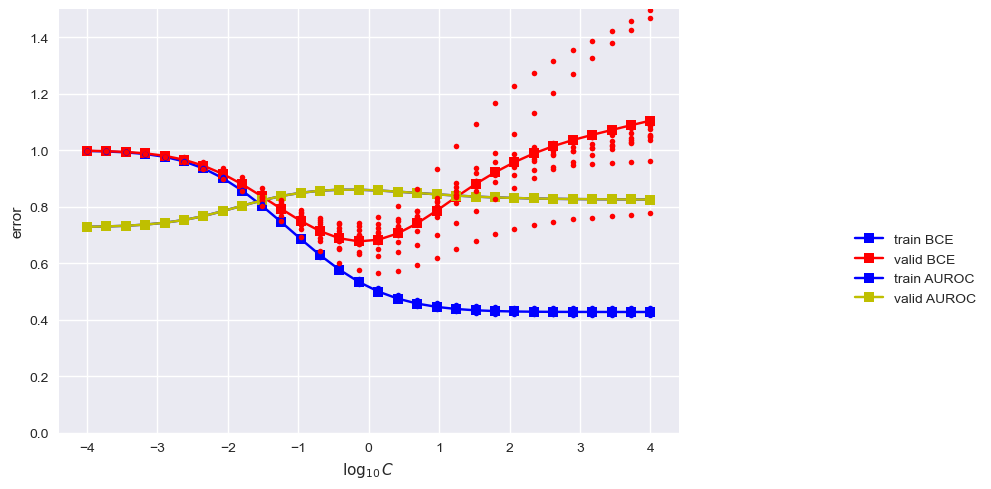

In [68]:
plt.plot(np.log10(C_grid), cv_tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), cv_va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_mean_cv_auroc_list, 'bs-', label='train AUROC')
plt.plot(np.log10(C_grid), va_mean_cv_auroc_list, 'ys-', label='valid AUROC')

for i in range(len(tr_bce_list_for_each_C)):
    for j in range(len(tr_bce_list_for_each_C[0])):
        plt.plot(np.log10(C_grid[i]), tr_bce_list_for_each_C[i][j], marker='o', color='blue', markersize = 4)
        plt.plot(np.log10(C_grid[i]), va_bce_list_for_each_C[i][j], marker='o', color='red', markersize = 4)
        
plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.5]);

In [69]:
# print("Best model has coefficient values:")
# print(best_lr.coef_)

In [70]:
prng = np.random.RandomState(101)

bestlr_yproba1_tr = best_lr.predict_proba(x_tr[best_fold_in_C])[:,1] # TODO fixme
bestlr_yproba1_va = best_lr.predict_proba(x_va[best_fold_in_C])[:,1] # TODO fixme

In [71]:
bestlr_yproba1_va.shape
y_va[best_fold_in_C].shape

(241,)

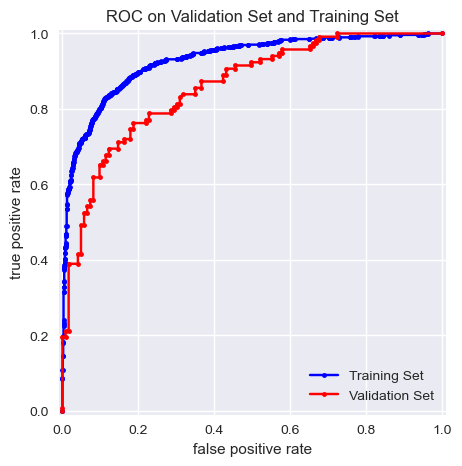

In [72]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 
va_fpr, va_tpr, va_thresholds = sklearn.metrics.roc_curve(y_va[best_fold_in_C], bestlr_yproba1_va)
tr_fpr, tr_tpr, tr_thresholds = sklearn.metrics.roc_curve(y_tr[best_fold_in_C], bestlr_yproba1_tr)

# Read HW2 instructions carefully for plot style (line type, line color, etc.)

plt.plot(tr_fpr, tr_tpr, 'b.-', label = "Training Set" )
plt.plot(va_fpr, va_tpr, 'r.-', label = "Validation Set" )
plt.title("ROC on Validation Set and Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

## Confusion Matrix on the best C/fold

In [73]:
import threshold_selection
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

In [74]:
best_thr_default = 0.5

print(sklearn.metrics.confusion_matrix(y_va[best_fold_in_C], bestlr_yproba1_va >= best_thr_default))

thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_va[best_fold_in_C], bestlr_yproba1_va, [best_thr_default])

tpr = perf_dict['tpr'][0]# TODO fixme
ppv = perf_dict['ppv'][0] # TODO fixme

print(f"chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

[[97 26]
 [28 90]]
chosen thr = 0.5000, tpr = 0.7627, ppv = 0.7759,


## Area Under ROC Curve

In [75]:
roc_auc_score(y_va[best_fold_in_C],bestlr_yproba1_va)

0.8602383905194984

## read the test file into vocab matrix

In [34]:
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
x_test_df.shape

(600, 2)

In [35]:
te_text_list = x_test_df['text'].values.tolist()
len(te_text_list)

600

In [36]:
vec = CountVectorizer(vocabulary = vocab)
t = vec.fit_transform(te_text_list)
t

<600x383 sparse matrix of type '<class 'numpy.int64'>'
	with 4203 stored elements in Compressed Sparse Row format>

In [37]:
te_array = t.toarray()
te_array.shape

(600, 383)

In [38]:
y_te_proba = best_lr.predict_proba(te_array)[:,1]
y_te_proba

array([3.62117697e-01, 4.72180984e-01, 2.78409223e-01, 8.65255762e-02,
       3.54889566e-01, 1.08060295e-01, 1.57990901e-01, 2.89400522e-01,
       2.79734130e-01, 4.33624473e-01, 2.97987867e-01, 5.77069316e-01,
       4.87571138e-02, 1.44773050e-01, 1.95076336e-01, 1.34307043e-01,
       2.13953540e-02, 1.57378146e-01, 3.96432188e-01, 4.97185700e-01,
       3.82591249e-01, 4.41435327e-01, 3.76786838e-01, 3.23295482e-01,
       4.13869410e-01, 2.37655858e-01, 2.63386315e-01, 4.41477171e-01,
       3.60970960e-01, 2.69489080e-01, 5.33938875e-01, 2.73708130e-01,
       5.17281599e-01, 2.52364560e-02, 1.94340706e-01, 6.26292351e-01,
       3.74095368e-01, 1.91349321e-01, 4.09070442e-01, 5.17582842e-01,
       9.30453240e-02, 3.69846490e-01, 5.32018458e-01, 2.87213335e-01,
       1.01586856e-01, 5.78762952e-02, 2.16254771e-01, 1.23482812e-01,
       8.82796498e-02, 3.60970960e-01, 4.21110929e-01, 1.63995347e-01,
       8.90356371e-01, 3.71454197e-01, 3.81115191e-01, 4.32061269e-01,
      

In [39]:
y_te_proba.shape, y_te_proba[5]

((600,), 0.10806029487743136)

In [40]:
# for i in range(y_te_proba.shape[0]):
#     if y_te_proba[i] >= 0.5: 
#         y_te_proba[i] = 1
#     else:
#         y_te_proba[i] = 0

In [41]:
# np.savetxt('out5.txt', y_te_proba, delimiter=' ')